# <center>  Diagramas de Ojo e Interferencia entre símbolos

## Ejercitación
A partir del código proporcionado en esta Notebook y la dirección ip del SDR asignado, resolver las siguientes consignas.


1. Partiendo de la configuración por defecto (loopback digital) y para un $\beta$ del filtro coseno realzado igual a 1, 0.75, 0.5 y 0.25: 

   1. ¿Como impacta el valor de $\beta$  en la respuesta al impulso del filtro?

   2. ¿Como impacta el valor de $\beta$ en la respuesta en frecuencia del filtro? y ¿Cuando el sistema es más inmune a un posible ruido gaussiano blanco?

   3. Para los distintos valores de $\beta$ ¿Se observa ISI en el diagrama de ojo para el instante de muestreo ideal? Justifique su respuesta.

   4. Analizando el diagrama de ojo para valores de $\beta$ cada vez mas pequeños ¿el sistema se vuelve más o menos sensible a un error en la fase del sincronismo? Justifique su respuesta.


2. Partiendo de la configuración por defecto (loopback digital) y para un $\beta = 0$ ¿Que es posible deducir del diagrama de ojo? y ¿Que filtro queda conformado para este valor de $\beta$?


3. Para una $\beta = 0.25$ y para cantidades de taps del filtro de $12 T_{symb}$, $8 T_{symb}$, $6 T_{symb}$ y $4 T_{symb}$ ¿Se produce algún tipo de pérdida de desempeño en el sistema? ¿A qué es debido? 


4. Configurando el sistema con un loopback desactivado (la señal sale e ingresa por antena) y un $\beta = 1$ ¿que conclusiones puede obtener al comparar este diagrama de ojo con el observando para el caso de loopback digital? Tenga en cuenta que posiblemente deba realizar varios intentos hasta obtener un diagrama de ojo adecuado. 
  

5. Una forma de reducir la relación señal a ruido (SNR) en la entrada del receptor es dismimuyendo la potencia de la señal de salida del transmisor, esto es haciendo cada vez más negativo el valor de "TxAtten". ¿Que conclusiones puede obtener de la observación del diagrama de ojo a medida que disminuye esta SNR con el sistema configurado con loopback en RF?  


6. Diseñe un código que reemplace el armado del diagrama de ojo realizado por la función "dc.eye_plot".

In [1]:
#------------------------------- Libraries ------------------------------- 

import adi
import numpy as np
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
import matplotlib.pyplot as plt

In [51]:
#------------------ Transmitter configuration parameters ------------------ 

num_bits    = 2**13   # Number of transmitted bits
sps         = 8       # Samples per symbol
span        = 12      # The filter is truncated to span symbols
beta        = 0.75       # Excess-bandwidth parameter

In [52]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.36" # RELLENAR CON LA IP DEL SDR ASIGNADO
SamplingRate     = 4e6               # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1                 # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 950e6             # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30               # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6               # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq          # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack"     # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0                 # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw            # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1
                 

In [53]:
#-------------------- Root Raised Cosine Filter Function --------------------

def rrcosdesign(beta,span,sps):
    index     = np.arange(-(span*sps)/2,(span*sps)/2+1,1)
    Ts        = sps
    rrcFilter = np.array([])

    for n in index:
        if beta == 0:
            aux       = np.sinc(n/Ts)/np.sqrt(Ts)
            rrcFilter = np.append(rrcFilter,aux)
        else:
            if n == Ts/(4*beta) or n == -Ts/(4*beta):
                aux       = beta*((np.pi+2)*np.sin(np.pi/(4*beta))+(np.pi-2)*np.cos(np.pi/(4*beta)))/(np.pi*np.sqrt(2*Ts))
                rrcFilter = np.append(rrcFilter,aux)
            else:
                a         = np.cos((1+beta)*np.pi*n/Ts)
                b         = (1-beta)*np.pi*np.sinc((1-beta)*n/Ts)/(4*beta)
                c         = 4*beta/(np.pi*np.sqrt(Ts))
                aux       = c*(a+b)/(1-(4*beta*n/Ts)**2)
                rrcFilter = np.append(rrcFilter,aux)
    return rrcFilter

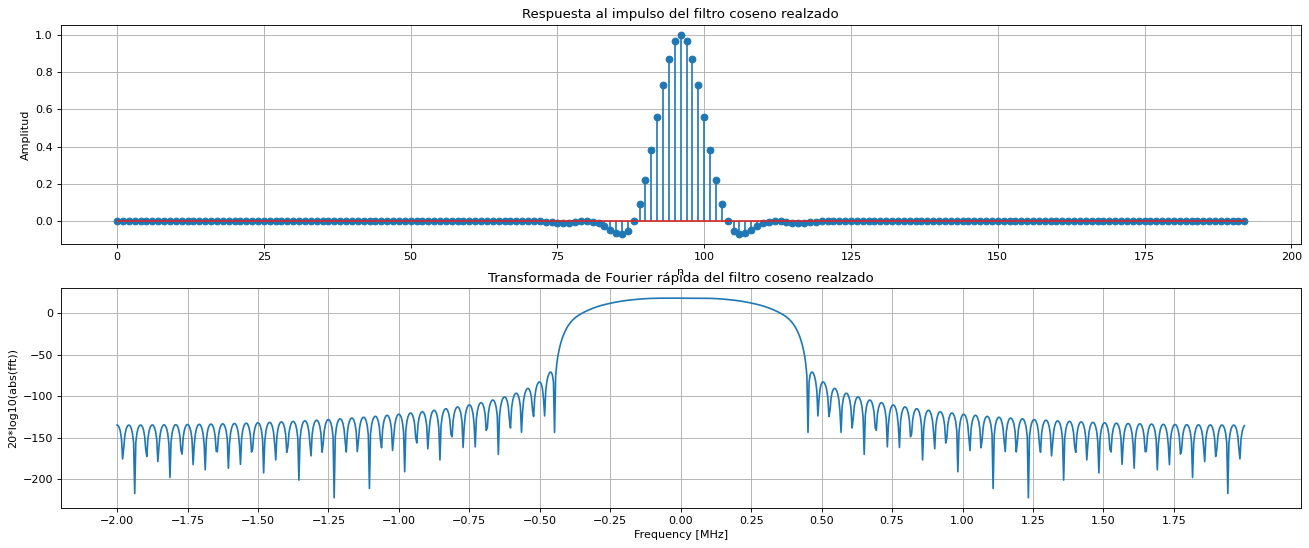

In [54]:
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

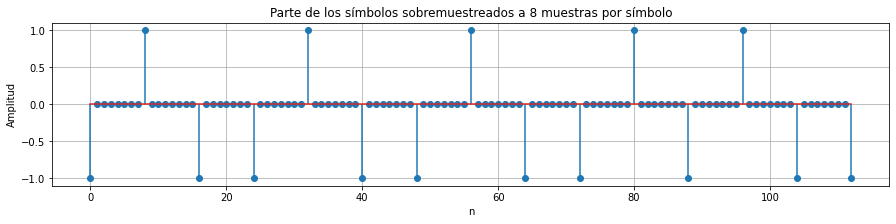

In [55]:
#------------------------------- Symbol Generator ------------------------------- 

bits       = np.random.randint(0, 2, num_bits)
symbolsUps = np.array([])

for bit in bits:
    pulse      = np.zeros(sps)
    pulse[0]   = bit*2-1 
    symbolsUps = np.concatenate((symbolsUps, pulse)) 
    
plt.figure(figsize=(15,3))
plt.stem(symbolsUps[0:113])
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title("Parte de los símbolos sobremuestreados a %i muestras por símbolo" %sps)
plt.grid()
plt.show()

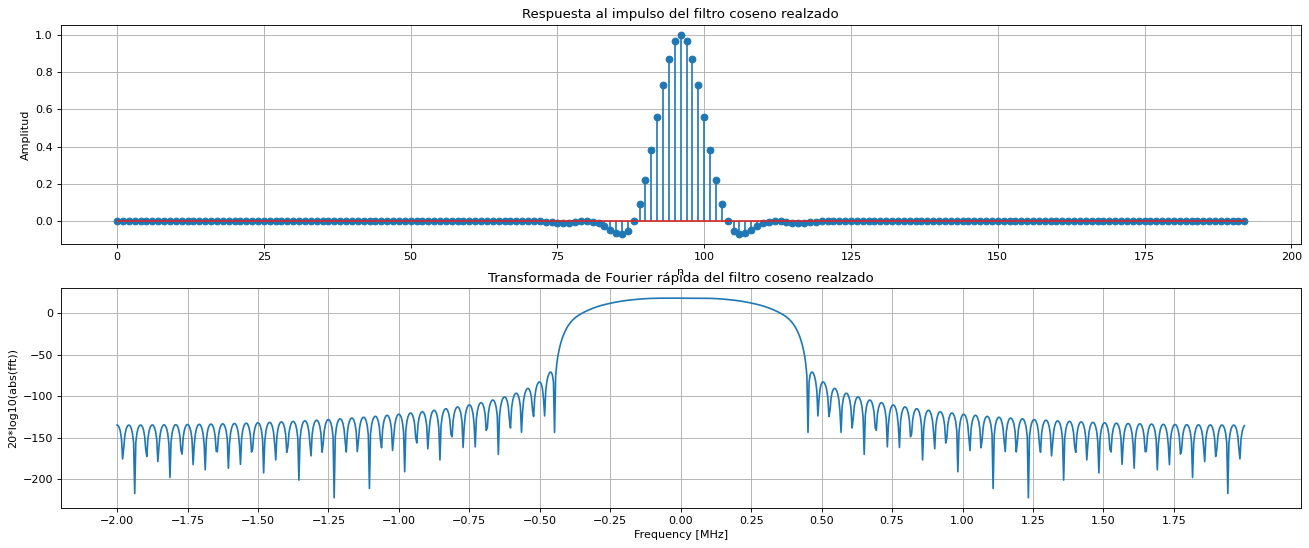

In [56]:
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

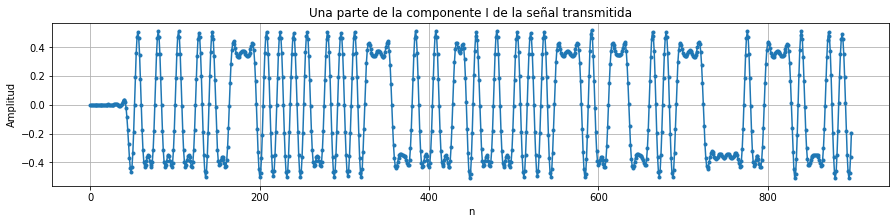

In [57]:
#------------------------------- Transmitted I component ------------------------------- 
txSignal = np.convolve(symbolsUps, rrcFilter)
plt.figure(figsize=(15,3))
plt.plot(txSignal[0:900], '.-')
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Una parte de la componente I de la señal transmitida')

plt.grid()
plt.show()

In [58]:
#------------------------------- SDR Setup ------------------------------- 

sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize


In [59]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(txSignal*2**14)

In [60]:
#------------------------------- Receiver ------------------------------- 

rxSignal = sdr.rx()/2**14

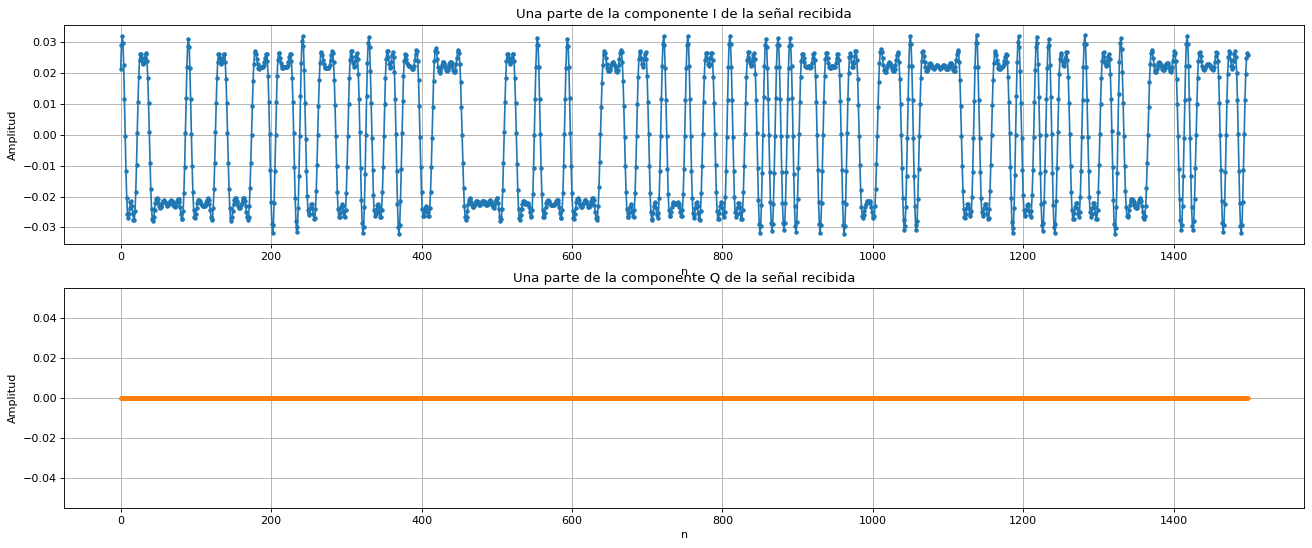

In [61]:
#------------------------------- Received I component ------------------------------- 
# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(np.real(rxSignal[0:1500]), '.-')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente I de la señal recibida')
plt.grid()

#------------------------------- Received Q component -------------------------------
# Plot time domain
plt.subplot(2,1,2)
plt.plot(np.imag(rxSignal[0:1500]), '.-C1')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente Q de la señal recibida')
plt.grid()
plt.show()

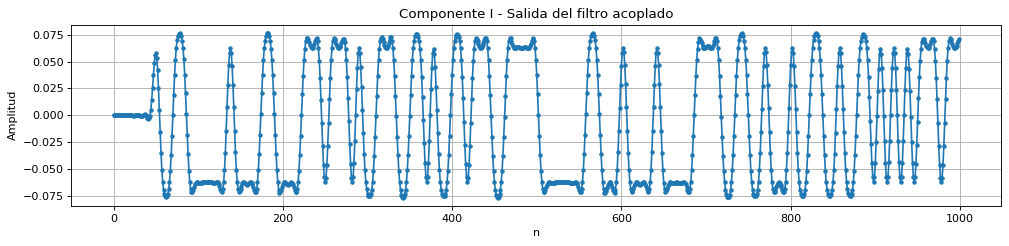

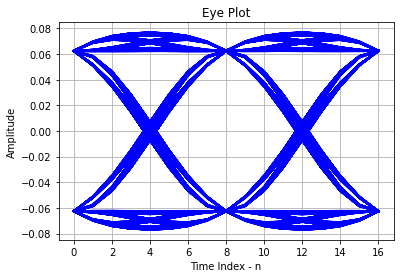

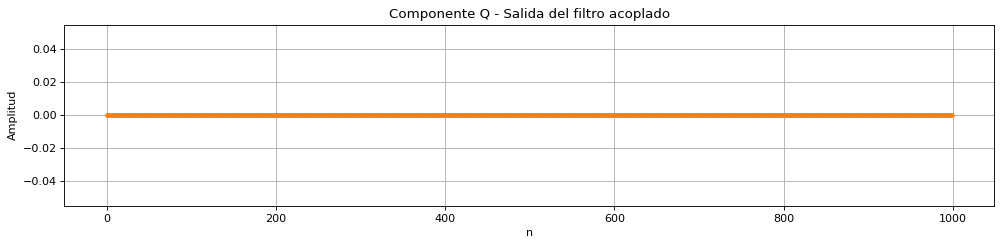

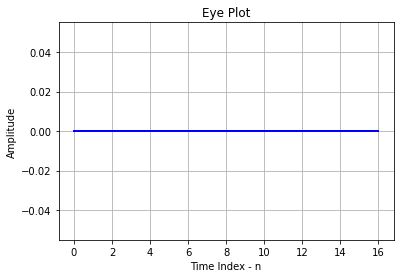

In [62]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

In [63]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0  = -70
sdr.rx_lo                  = int(2400e6)
sdr.tx(np.zeros(1024))

In [64]:
# Destroy radio object
del(sdr)

## Resolucion de las consignas:

##### 1).

A) Cuando variamos el valor del $\beta$ observamos el cambio de la respusta en el filtro, cuando ponemos un valor de 1 vemos a la forma raiz coseno realzado, mirando el grafico en el tiempo vemos una rapida atenuación de las colas de la función, a medida que aumentamos el valor del $\beta$ observamos que las colas se van atenuando cada vez mas lento y la función en el tiempo toma una forma mas parecida a una sinc

B) Observamos que cuando tenemos un $\beta$ = 1 la transformada presenta una mayor frecuencia, tambien notamos que cuando es igual a 1, el ancho de banda es el doble del ancho de banda de Nyquist, en cambio si disminuimos el $\beta$, vemos como esa frecuencia disminuye, un $\beta$ igual a 0 significa que el filtro tiene un ancho de banda minimo.

Si el $\beta$ es menor, la relación SNR  sera mejor debido a filtra mas ruido de alta frecuencia pero esto traera como problemas en un aumento de ISI

Un mayor $\beta$ reducira el efecto ISI pero a su vez esto permitira que pase mas ruido.

En conclusión lo mejor seria usar un $\beta$ intermedio como por ejemplo 0,5

C) Si utilizamos un $\beta$ = 0, observamos que el efecto ISI debido a que estamos enfocados en minimizar mucho el ruido pero esto nos provoca ISI, a medida que vamos aumentando el $\beta$ notamos una gran mejora en cuanto al efecto ISI. Cuando cambiamos el $\beta$ a 0.25 se puede notar aun que el efecto ISI sigue apreciandose pero en muy menor medida que cuando $\beta$ es 0, apartir de 0.5 ya no se aprecia ISI en el diagrama de ojo. Esto de notar ISI para $\beta$ <= 0.25 puede deberse a que se realizan transiciones mas abruptas, esto puede verse graficamente en la respuesta del filtro, entre la banda de paso y la que es eliminada, tambien otro problema puede deberse a una respuesta temporal mas larga debido a que la función tarda mas en atenuar sus colas y ademas reduce el ancho de banda, entonces el mismo puede ser no suficiente para capturar todo lo que se ha transmitido

D) Utilizando las respuestas antes redactadas y observando el cambio del diagrama mientras se cambian los valores de $\beta$ se puede concluir que el sistema se vuelve mas sensible a los errores, esto trae como consecuencia un mayor ISI con errores de sincronismo. Esto puede estar debido a el tema de las transiciones abruptas, problemas de muestreo y la disminución del ancho de banda por $\beta$ mas pequeños

##### 2).
Observamos que para un $\beta$ igual a cero hay bastante ISI, notar tambien que para ese $\beta$ el ruido seria minimo pero tiene aparajado como consecuencia problemas de ISI.
El ruido seria menor debido a un menor ancho de banda en frecuencia. 

La respuesta en el filtro es lo mas parecido a un sinc en el tiempo y en frecuencia podemos observar tambien como trata de parecerse a una funcion cuadrada

##### 3).
Para $\beta$ = 0,25 con loopback en digital y 12 taps vemos lo siguiente:

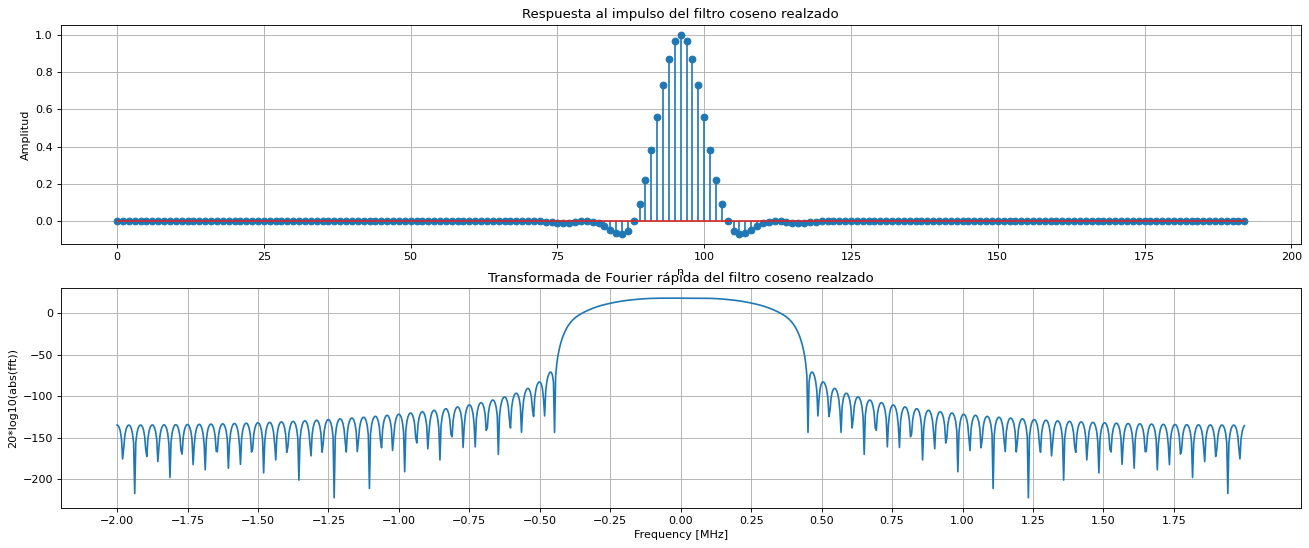

In [65]:
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

Para $\beta$ = 0,25 con loopback en digital y 8 taps vemos lo siguiente:

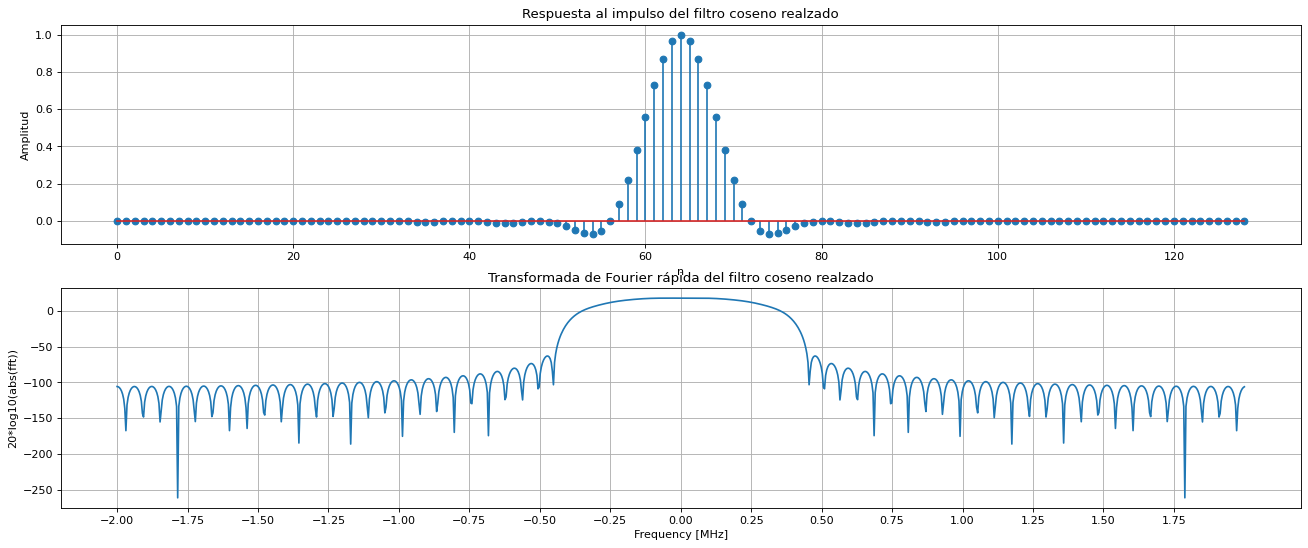

In [66]:
span        = 8
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

Para $\beta$ = 0,25 con loopback en digital y 6 taps vemos lo siguiente:

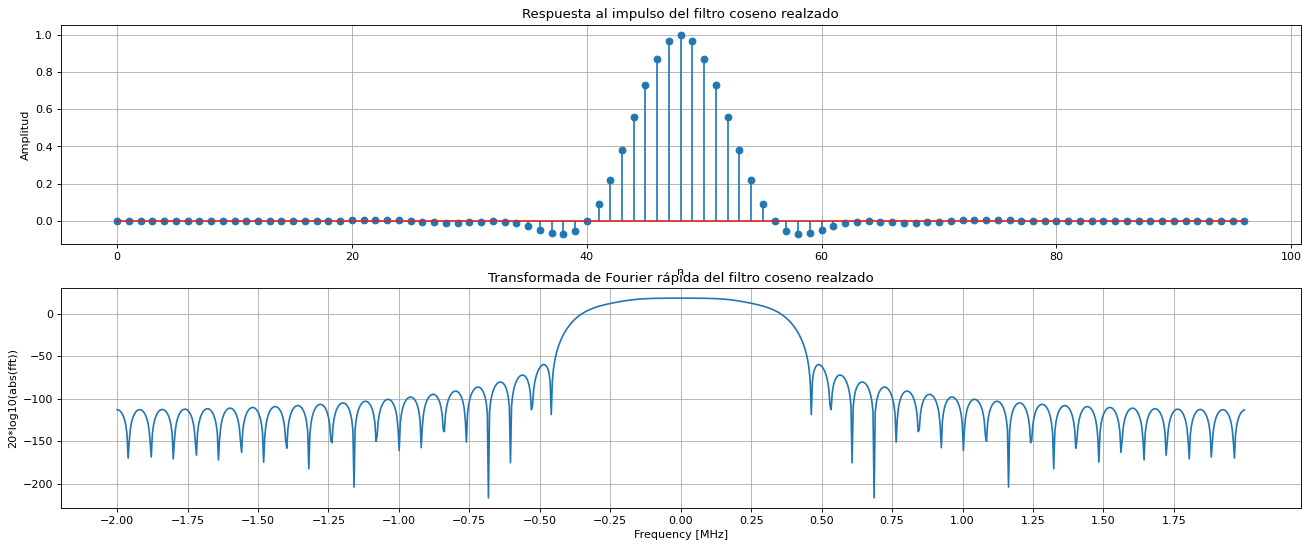

In [67]:
span        = 6
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

Para $\beta$ = 0,25 con loopback en digital y 4 taps vemos lo siguiente:

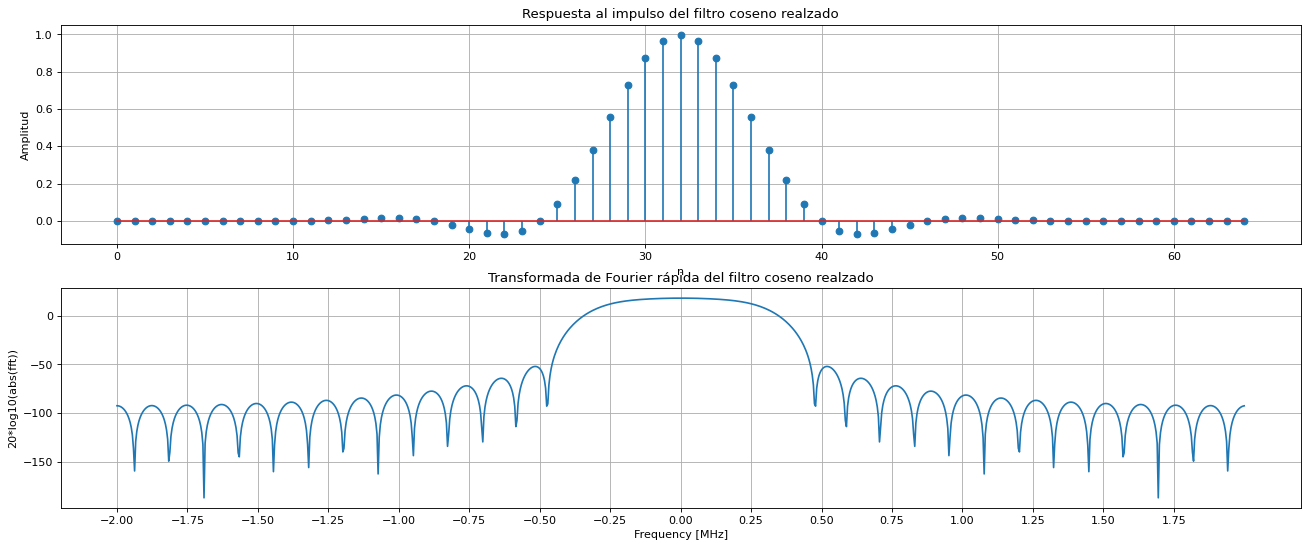

In [68]:
span        = 4
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

Podemos observar en la imagenes como el a medida que vamos disminuyendo los taps se reduce la capacidad del filtro para discriminar entre frecuencias deseadas e indeseadas lo que quiere que tendra una respuesta en frecuencia menos precisa. Ademas la reducción del numero de taps provoca un aumento del ISI, esto tambien se puede observar mirando los diagramas de ojo

##### 4).

Para $\beta$ = 1 con loopback activado vemos lo siguiente:

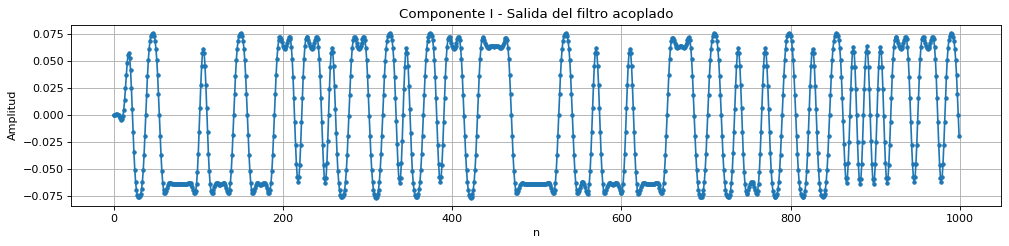

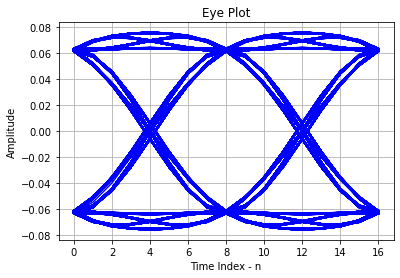

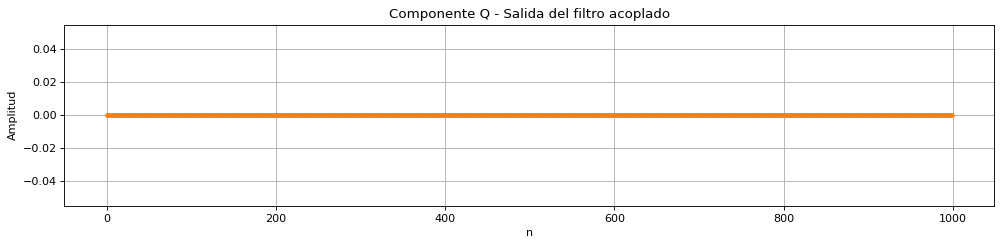

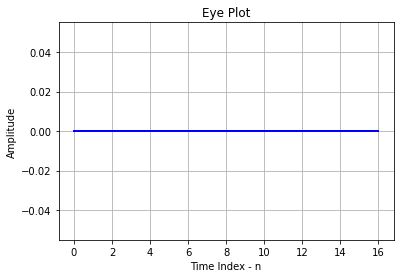

In [69]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()


Para $\beta$ = 1 con loopback desactivado vemos lo siguiente:

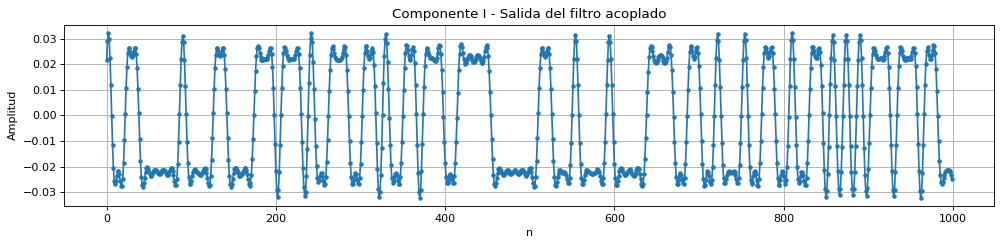

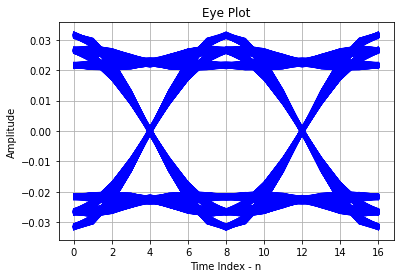

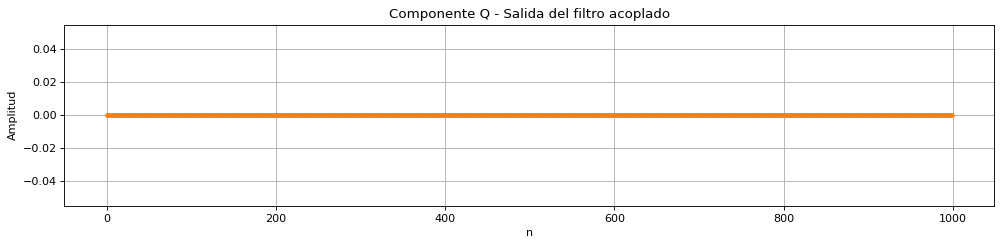

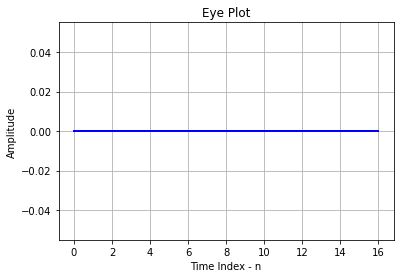

In [70]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.real(rxSignal)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.imag(rxSignal)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

Como conclusión podemos notar que cuando el loopback esta desactivado el diagrama se ve limpio y sin ruido añadido, en cambio cuando activamos el loopback vemos que ahora el grafico presenta ruido debido a que ya no lo estamos mandando por la parte digital sino que estamos enviando la información de una antena del SDR a otra y observamos en el ruido ambiente del lugar. Ademas notar que con el loopback activado tenemos presencia de ISI

##### 5).

En este apartado usar un TxAtten - 20 empezando por -30 con loopback configurado en RF:
Para $\beta$ = 1, TxAtten = -30 obtenemos:

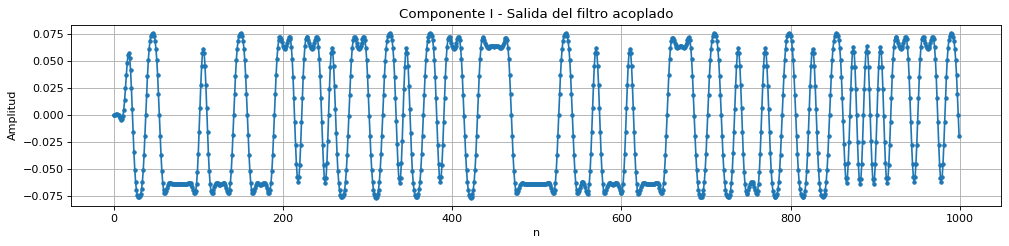

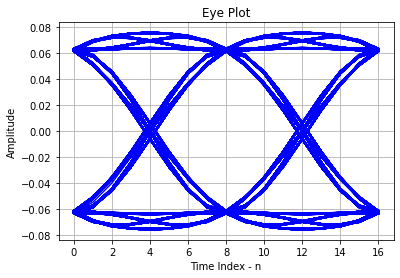

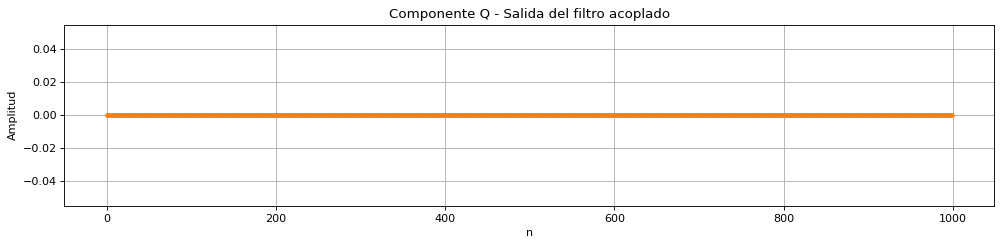

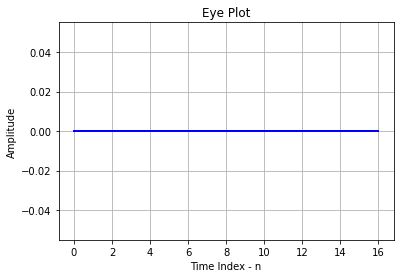

In [71]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

Para $\beta$ = 1, TxAtten = -50 obtenemos:

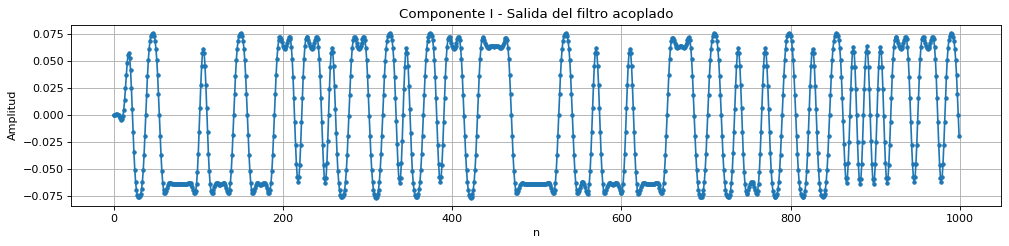

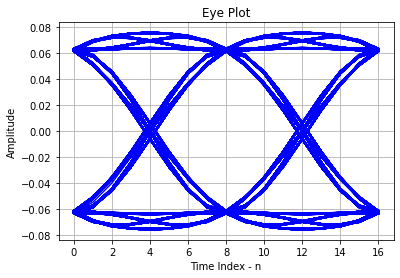

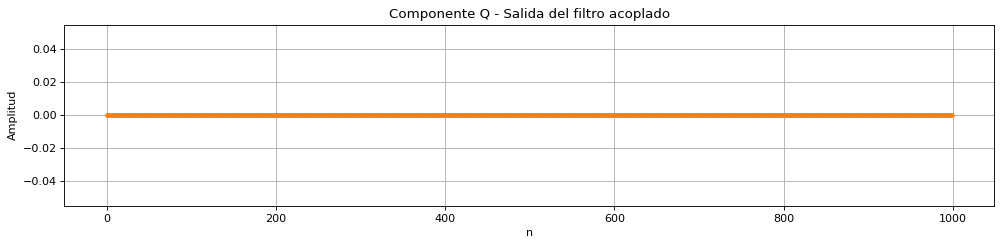

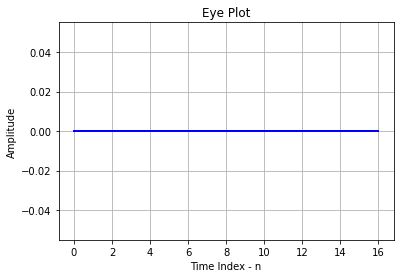

In [72]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

Para $\beta$ = 1, TxAtten = -70 obtenemos:

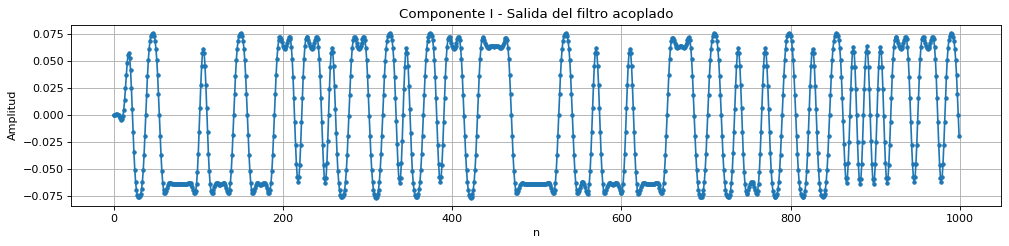

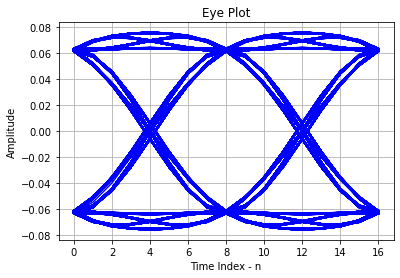

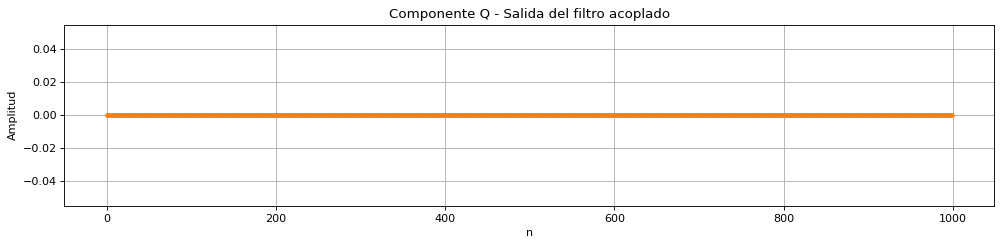

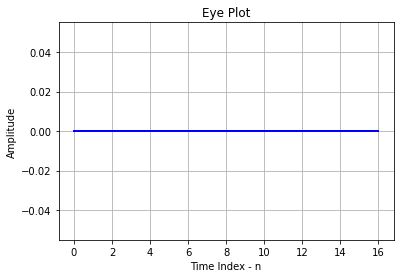

In [73]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

Para $\beta$ = 1, TxAtten = -80 obtenemos:

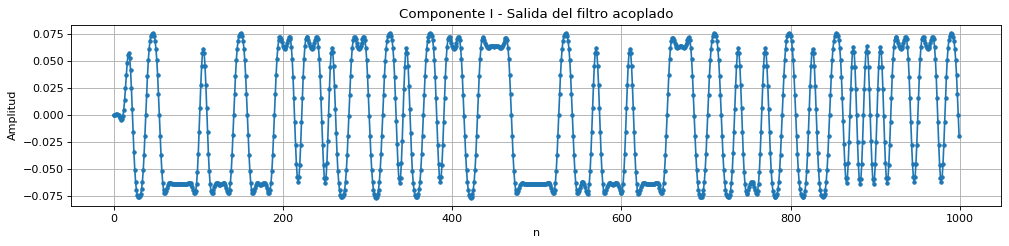

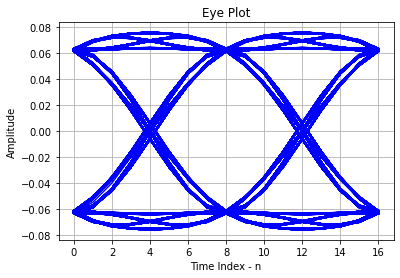

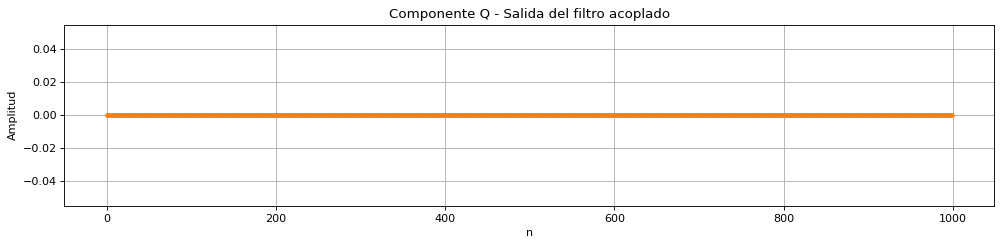

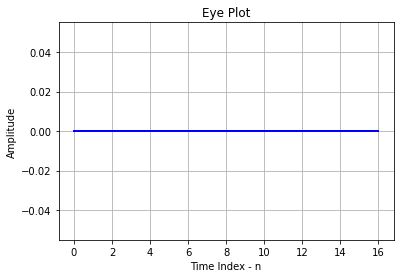

In [74]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

Como conclusión podemos ver que se atenua demasiado la transmisión y no llega a verse nada visible mas que ruido al final. La SNR disminuye debido a que la potencia disminuye pero al ser tan baja se hace mas probable que ocurran interferencias y ruido. Entonces concluyo en que para realizar correctamente este procedimiento se debe bajar de a menos decibelios e ir monitoriando hasta encontrar una señal con un buen balance

##### 6).

In [75]:
#------------------ Transmitter configuration parameters ------------------ 

num_bits    = 2**13   # Number of transmitted bits
sps         = 8       # Samples per symbol
span        = 12      # The filter is truncated to span symbols
beta        = 1       # Excess-bandwidth parameter

In [76]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.33" # RELLENAR CON LA IP DEL SDR ASIGNADO
SamplingRate     = 4e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1             # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 922e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1
                 

In [77]:
#-------------------- Root Raised Cosine Filter Function --------------------

def rrcosdesign(beta,span,sps):
    index     = np.arange(-(span*sps)/2,(span*sps)/2+1,1)
    Ts        = sps
    rrcFilter = np.array([])

    for n in index:
        if beta == 0:
            aux       = np.sinc(n/Ts)/np.sqrt(Ts)
            rrcFilter = np.append(rrcFilter,aux)
        else:
            if n == Ts/(4*beta) or n == -Ts/(4*beta):
                aux       = beta*((np.pi+2)*np.sin(np.pi/(4*beta))+(np.pi-2)*np.cos(np.pi/(4*beta)))/(np.pi*np.sqrt(2*Ts))
                rrcFilter = np.append(rrcFilter,aux)
            else:
                a         = np.cos((1+beta)*np.pi*n/Ts)
                b         = (1-beta)*np.pi*np.sinc((1-beta)*n/Ts)/(4*beta)
                c         = 4*beta/(np.pi*np.sqrt(Ts))
                aux       = c*(a+b)/(1-(4*beta*n/Ts)**2)
                rrcFilter = np.append(rrcFilter,aux)
    return rrcFilter

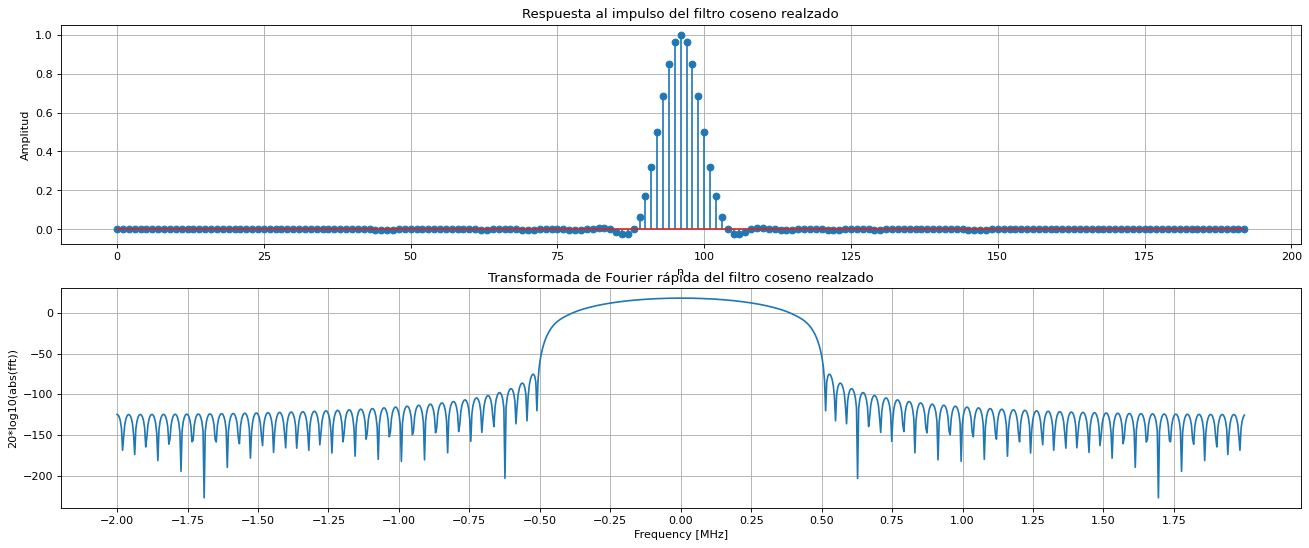

In [78]:
#-------------------- Root Raised Cosine Filter Design --------------------

rrcFilter = rrcosdesign(beta,span,sps)
#rrcFilter = rrcosfilter(span*sps, beta, Ts=1, Fs=sps)[1]

#-------------------- Matched Filter Design --------------------

matchedFilter = np.conj(rrcosdesign(beta,span,sps))
#matchedFilter = np.conj(rrcosfilter(span*sps, beta, Ts=1, Fs=sps))[1]

#-------------------- Raised Cosine Filter --------------------

rcFilter = np.convolve(rrcFilter,matchedFilter)

# Calculate fft
abs_fft    = np.abs(np.fft.fftshift(np.fft.fft(rcFilter,n = 1024)))
abs_fft_dB = 10*np.log10(abs_fft**2)
frec       = np.linspace(SamplingRate/-2, SamplingRate/2, len(abs_fft))

# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.stem(rcFilter)
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Respuesta al impulso del filtro coseno realzado')
plt.grid()
# Plot freq domain
plt.subplot(2,1,2)
plt.plot(frec/1e6, abs_fft_dB)
plt.xticks(np.arange(min(frec/1e6), max(frec/1e6), 0.25))
plt.xlabel("Frequency [MHz]")
plt.ylabel("20*log10(abs(fft))")
plt.title('Transformada de Fourier rápida del filtro coseno realzado')
plt.grid()
plt.show()

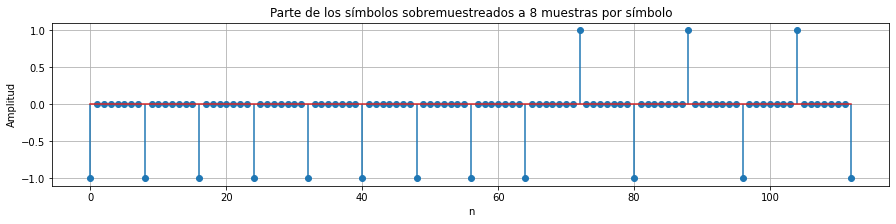

In [79]:
#------------------------------- Symbol Generator ------------------------------- 

bits       = np.random.randint(0, 2, num_bits)
symbolsUps = np.array([])

for bit in bits:
    pulse      = np.zeros(sps)
    pulse[0]   = bit*2-1 
    symbolsUps = np.concatenate((symbolsUps, pulse)) 
    
plt.figure(figsize=(15,3))
plt.stem(symbolsUps[0:113])
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title("Parte de los símbolos sobremuestreados a %i muestras por símbolo" %sps)
plt.grid()
plt.show()

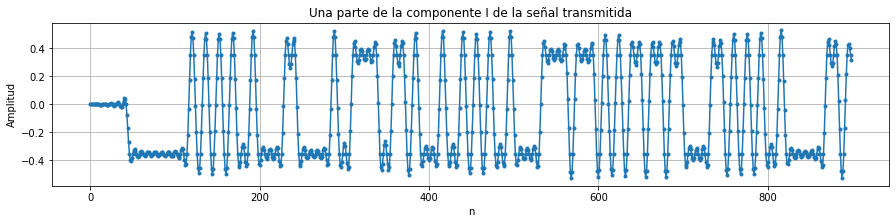

In [80]:
#------------------------------- Transmitted I component ------------------------------- 
txSignal = np.convolve(symbolsUps, rrcFilter)
plt.figure(figsize=(15,3))
plt.plot(txSignal[0:900], '.-')
plt.xlabel("n")
plt.ylabel("Amplitud")
plt.title('Una parte de la componente I de la señal transmitida')

plt.grid()
plt.show()

In [81]:
#------------------------------- SDR Setup ------------------------------- 

sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize


In [82]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(txSignal*2**14)

In [83]:
#------------------------------- Receiver ------------------------------- 

rxSignal = sdr.rx()/2**14

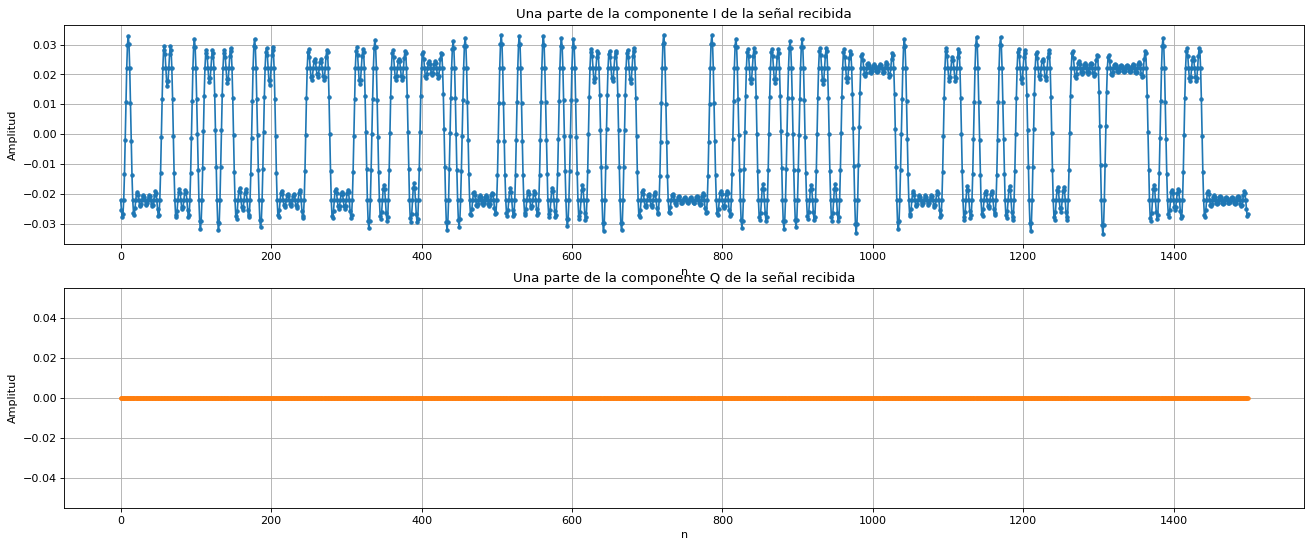

In [84]:
#------------------------------- Received I component ------------------------------- 
# Plot time domain
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(np.real(rxSignal[0:1500]), '.-')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente I de la señal recibida')
plt.grid()

#------------------------------- Received Q component -------------------------------
# Plot time domain
plt.subplot(2,1,2)
plt.plot(np.imag(rxSignal[0:1500]), '.-C1')
plt.xlabel('n')
plt.ylabel('Amplitud')
plt.title('Una parte de la componente Q de la señal recibida')
plt.grid()
plt.show()

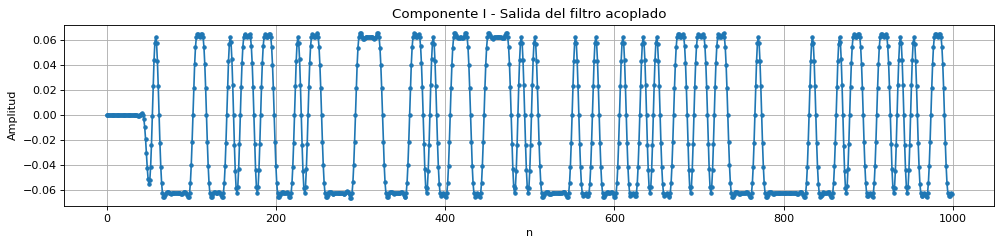

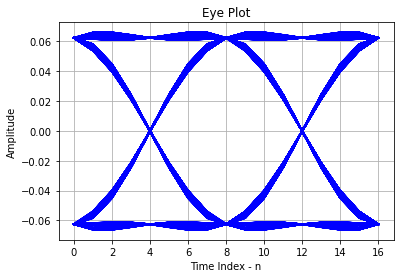

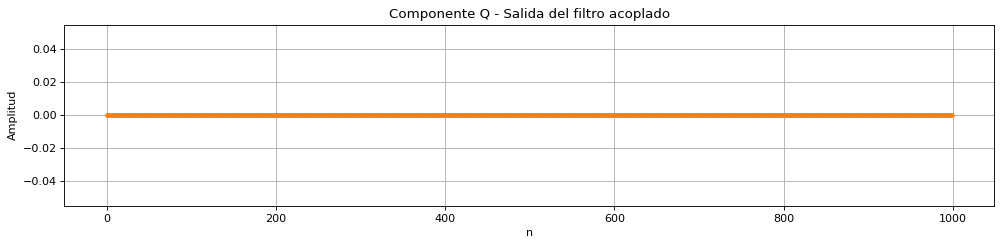

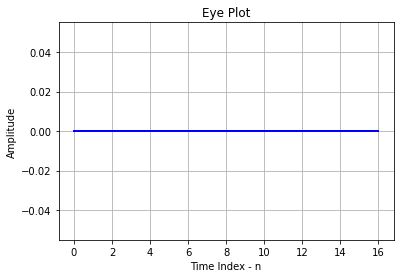

In [85]:
#------------------------------- Filtered I component -------------------------------

iRxFilSignal = np.convolve(np.real(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iRxFilSignal[0:1000],'.-')
plt.title('Componente I - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

corr     = signal.correlate(np.real(txSignal), np.real(rxSignal), mode="full")
lags     = signal.correlation_lags(len(txSignal), len(rxSignal), mode="full")
Rmax_pos = np.argmax(corr)

#------------------------------- Eye Diagram -------------------------------

i_Signal = iRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
L        = sps*2           # display length in samples (usually two symbols)
S        = 0               # start index
dc.eye_plot(i_Signal,L,S)
plt.show()

#------------------------------- Filtered Q component -------------------------------

qRxFilSignal = np.convolve(np.imag(rxSignal),matchedFilter)
plt.figure(figsize=(15, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(qRxFilSignal[0:1000],'.-C1')
plt.title('Componente Q - Salida del filtro acoplado')
plt.ylabel('Amplitud')
plt.xlabel('n')
plt.grid()
plt.show()

#------------------------------- Eye Diagram -------------------------------

q_Signal = qRxFilSignal[-lags[Rmax_pos]+2*span*sps:-lags[Rmax_pos]+len(txSignal)-2*span*sps] 
dc.eye_plot(q_Signal,L,S)
plt.show()

In [86]:
def eyePlot(signal, l, s=0, title = 'Eye Plot'):
    plt.figure(figsize=(6,4))
    a = np.arange(0, l + 1)
    plt.plot(a, signal[s:s + l + 1], 'r')
    i_max = int((len(signal) - s) / l) - 1
    for i in range(1,i_max):
        plt.plot(a, signal[s + i * l:s + l + 1 + i * l], 'r')
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Eye Plot')
    return 0

0

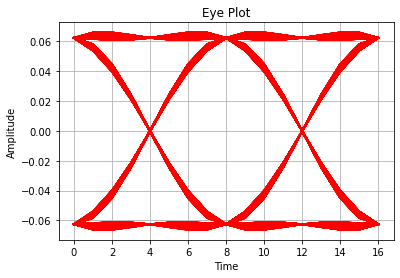

In [87]:
eyePlot(i_Signal, L)

In [88]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0  = -70
sdr.rx_lo                  = int(2400e6)
sdr.tx(np.zeros(1024))

In [89]:
# Destroy radio object
del(sdr)